# Pre-processing input data
* Data
    * In this task, we first load data given in Excel sheet. The data contains comments by viewers on contact lenses that they purchased. We want to tokenize the data
    and do
    * Sentiment Analysis
    * Topic determination

* We download nltk wordnet which provides us with a vocabulary of words, that we use to build our dictionary
* We also guess the gender using gender guesser package

In [1]:
%matplotlib inline
%timeit
import pandas as pd
import string
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import sys
from collections import Counter
import random
import ast
import re
import scipy

sys.path.append('pymodules')
# This class contains some utility functions Word2Vec, stop words etc. etc.
import pymodules.preprocessing_class as pc

# gender gueser
import gender_guesser.detector as gd

# for dictionary method synonym finder using wordnet
import nltk
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')
try:
    nltk.data.find('corpora/omw-1.4')
except LookupError:
    nltk.download('omw-1.4')

from nltk.corpus import wordnet as wn

/Users/bmukund/miniconda3/lib/python3.8/site-packages/spacy/util.py:837: UserWarning: [W095] Model 'en_core_web_sm' (3.2.0) was trained with spaCy v3.2 and may not be 100% compatible with the current version (3.3.0). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


### Find synonyms to add to the vocabulary of words.
This is required for sentiment analysis so that most of the comment words by users are captured

In [2]:
def find_wordnet_synonyms(word_list, type_of_word=None):
    """
    Function to find synonyms of words given in the input respecting the type of word (noun or adjective or verb)
    It is assumed that the word_list, the input is a list
    @return lemmatized synonyms
    """
    synonyms = set()
    for word_to_look in word_list:
        #print(f"looking for synonyms of word:{word_to_look}")
        for syn in wn.synsets(word_to_look, pos=type_of_word):
            for i in syn.lemmas():
                synonyms.add(i.name())
    #print(f"Synonyms:\n {synonyms}")
    return synonyms

### Extract first name
* Used in guessing gender

In [3]:
def first_name(x):
    """
    Function to get the first name so that we can guess the gender
    * We determine the first name from the given string.
    * We also remove any digits from the name.
    * We use Space to split names
    """
    x_split = str(x).split()
    fname = x_split[0]
    # remove reference to digits. Now after removal, there could be some misclassification, but that is ok ..
    fname_p = re.sub(r'[0-9]+', "", fname)
    ret_str = fname_p.capitalize()
    return ret_str


### Excel File reader
* The date is used as index
* Depending on time of the year, comments may vary. So we can group data by dates and do analysis if required

In [4]:
def read_input(filename, sheet_name, filter_columns):
    df = pd.read_excel(filename, sheet_name=sheet_name, index_col='REVIEW_DATE')
    df  = df.drop(columns = filter_columns, axis=1)
    return df

## Start EDA analysis of input data

In [5]:
filename = "data/Master-data_Q42021.xlsx"
sheet_name = 'Scrubbed_data'
# We don't need these columns
not_needed = ['OVERALL_RATING', 'COMFORT_RATING', 'VISION_RATING', 'VALUE_FOR_MONEY', 'PROS', 'CONS', 'ORIGINAL_SOURCE', 'REPLY_FROM_ACCUVUE',
              'PRODUCT_LINK', 'WEBSITE']

text_data = read_input(filename, sheet_name, not_needed)

## Figure out the gender distribution
* It is interesting to note that majority of comments are by female, twice as much femals have commented compared to males

In [6]:
# Let us figure out the gender from the names and drop the names column
# We use gender_guesser package.
#text_data['AUTHOR'] = text_data['AUTHOR'].astype(str)
gdx = gd.Detector()
text_data['GENDER'] = text_data.AUTHOR.apply(first_name).map(lambda x: gdx.get_gender(x))

# Drop the author column now
text_data.drop(columns = ['AUTHOR'], axis=1, inplace=True)

<AxesSubplot:>

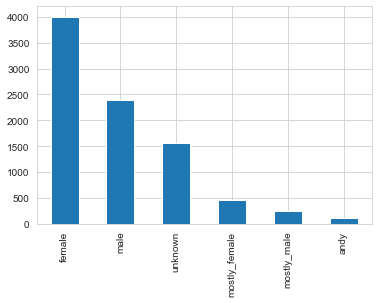

In [7]:
# Check the gender counts just to see how the data looks like
text_data.GENDER.value_counts().plot(kind='bar')

## Extract comments of the users
* Comments are found in two columns 'COMMENTS' column and 'TITLE' column.
    * This is because when the user inputs his/her reviews, sometimes they put their comments in the title itself and not in the box for comments. We need to take care of that too.
* Consolidate the comments into one column called 'COMMENT'.
* Comments can occur both in title and in Comment columns.

In [8]:
# Consolidate the comments into one column
# Comments can occur both in title and in Comment columns. 
text_data['COMMENT'] = text_data['TITLE'].astype(str).fillna("") + " " + text_data['COMMENTS'].astype(str).fillna("")
text_data.drop(columns = ['TITLE', 'COMMENTS'], axis=1, inplace=True)

## Find user review rating
* This is our response variable, the output variable
* Ratings are curated so that they are all integers.
* Ratings vary from [0-5]

In [9]:
# clean rating
# replace N = No rating with 0. We do this because rating is assumed to be numeric, not categorical
text_data['RATING'].replace('N', '0', inplace=True)
# convert rating to integers
text_data['RATING'] = text_data['RATING'].apply(lambda x: int(x))

### Plot rating

In [10]:
text_data['RATING']

REVIEW_DATE
2021-11-01    5
2021-12-02    4
2021-12-01    4
2021-11-16    5
2021-12-08    4
             ..
2021-11-29    5
2021-11-23    5
2021-12-27    5
2021-10-16    1
2021-12-05    5
Name: RATING, Length: 8794, dtype: int64

<AxesSubplot:ylabel='Density'>

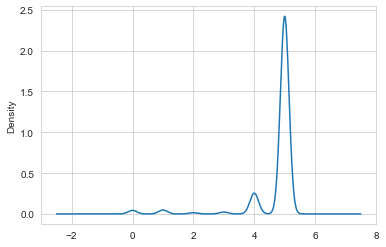

In [11]:
text_data['RATING'].plot(kind='density')

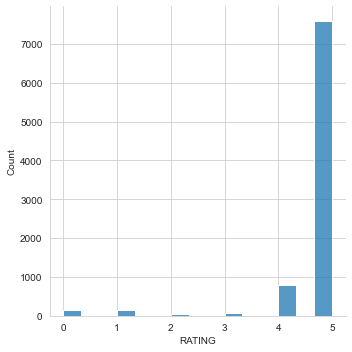

In [12]:
import seaborn as sns
sns.displot(text_data, x="RATING")

### Check output

In [13]:
# display results
text_data

,FINAL_PRODUCT_NAME,RATING,PRODUCT,BRAND,GENDER,COMMENT
REVIEW_DATE,,,,,,
2021-11-01,Acuvue 2 Contact Lenses ...,5,Acuvue2,Acuvue,male,Acucue 2 Contact Lenses I have used these lens...
2021-12-02,Acuvue 2 Contact Lenses ...,4,Acuvue2,Acuvue,female,Clear vision Tends to cloud up
2021-12-01,Acuvue 2 Contact Lenses ...,4,Acuvue2,Acuvue,female,comfort These are very hard to handle. Flimsy ...
2021-11-16,Acuvue 2 Contact Lenses ...,5,Acuvue2,Acuvue,male,Easy to use I have been using this product for...
2021-12-08,Acuvue 2 Contact Lenses ...,4,Acuvue2,Acuvue,unknown,Excellent Excellent got promised a discount of...
...,...,...,...,...,...,...
2021-11-29,Acuvue VITA Contact Lenses ...,5,Vita,Acuvue,male,"Truly the Best The price, fast shipping, quic..."
2021-11-23,Shop Acuvue Vita 12 pack (1.0 Box ),5,Vita,Acuvue,male,Very Comfortable Acuvue Vita are very comfort...
2021-12-27,Acuvue Vita for Astigmatism Contact Lenses,5,Vita,Acuvue,male,Very Comfortable and Convenient Very Comfortab...


### Tokenization <a class="anchor" id="first-bullet"></a>
* Based on tokenization http://sentiment.christopherpotts.net/code-data/happyfuntokenizing.py
* A tokenizer is a function that splits a string of text into words based on some delimiter that separates the strings.
* In this usae case, we use a regular expression to determine what a word means. Typically comments ca ne equated to tweets
  in its brevity and also for the language used. Hence we use the same regular expressions as we would for parsing a tweet.

In [14]:
## regex for tokenization
# Ref: http://sentiment.christopherpotts.net/code-data/happyfuntokenizing.py
emoticon_string = r"""
    (?:
      [<>]?
      [:;=8]                     # eyes
      [\-o\*\']?                 # optional nose
      [\)\]\(\[dDpP/\:\}\{@\|\\] # mouth
      |
      [\)\]\(\[dDpP/\:\}\{@\|\\] # mouth
      [\-o\*\']?                 # optional nose
      [:;=8]                     # eyes
      [<>]?
    )"""

# The components of the tokenizer:
regex_strings = (
    # Phone numbers:
    r"""
    (?:
      (?:            # (international)
        \+?[01]
        [\-\s.]*
      )?
      (?:            # (area code)
        [\(]?
        \d{3}
        [\-\s.\)]*
      )?
      \d{3}          # exchange
      [\-\s.]*
      \d{4}          # base
    )"""
    ,
    # Emoticons:
    emoticon_string
    ,
    # HTML tags:
    r"""<[^>]+>"""
    ,
    # Twitter username:
    r"""(?:@[\w_]+)"""
    ,
    # Twitter hashtags:
    r"""(?:\#+[\w_]+[\w\'_\-]*[\w_]+)"""
    ,
    # Remaining word types:
    r"""
    (?:[a-z][a-z'\-_]+[a-z])       # Words with apostrophes or dashes.
    |
    (?:[+\-]?\d+[,/.:-]\d+[+\-]?)  # Numbers, including fractions, decimals.
    |
    (?:[\w_]+)                     # Words without apostrophes or dashes.
    |
    (?:\.(?:\s*\.){1,})            # Ellipsis dots.
    |
    (?:\S)                         # Everything else that isn't whitespace.
    """,
    r"""
    (?x)                # set flag to allow verbose regexps (to separate logical sections of pattern and add comments)
    \w+(?:-\w+)*        # preserve expressions with internal hyphens as single tokens
    | [][.,;"'?():-_`]  # preserve punctuation as separate tokens
    """
)
word_re = re.compile(pattern=r"""(%s)""" % "|".join(regex_strings), flags=re.VERBOSE | re.I)

/var/folders/bk/93tv9tk147s32tbjbfrfb79w0000gn/T/ipykernel_38924/4173119622.py:65: DeprecationWarning: Flags not at the start of the expression '(\n    (?:\n      (?: ' (truncated)
  word_re = re.compile(pattern=r"""(%s)""" % "|".join(regex_strings), flags=re.VERBOSE | re.I)


### Tokenize using regex
* We take the data consolidated in 'COMMENT' column of dataframe and tokenize it as follows
* We convert all text to lower case
* We remove commonly used stop words and prepositions such as 'in', 'with'. These stopwords have been compiled for us and we simply use a database of stop words
* We do a lazy tokenization, in that we take all the required inputs and create an object called 'RawDocs'
    * class RawDocs has a lot of functions other than tokenization, (for example, join two consecutive words (bi-gramming), lemmatization etc.)
* We use a list of "short" stop words. Further, we remove "not", "no" etc. from the stop words list because we need such words to be counted as legitimate words for sentiment analysis

In [15]:
comments_data = text_data.COMMENT
prep_comments = pc.RawDocs(comments_data,  # series of documents
                  lower_case=True,  # whether to lowercase the text in the firs cleaning step
                  stopwords='short',  # type of stopwords to initialize
                  contraction_split=True,  # wheter to split contractions or not
                  tokenization_pattern=word_re  # custom tokenization patter
                  )

* We should notice that the RawDocs object created is identical to the input data

In [16]:
#comments_data
i = 0
print(f"Document data at index[{i}:\n {comments_data[i]}")
print("\n-------------------------\n")
print(f"Document data after objectifying input with tokenization procedures added[{i} :\n {prep_comments.docs[i]}")


Document data at index[0:
 Acucue 2 Contact Lenses I have used these lenses for a long time and I have to say that the service from Lens.com is great and the lenses work great for my needs!  I highly recommend them!

-------------------------

Document data after objectifying input with tokenization procedures added[0 :
 Acucue 2 Contact Lenses I have used these lenses for a long time and I have to say that the service from Lens.com is great and the lenses work great for my needs!  I highly recommend them!


### Basic cleaning
* Remove stop words. One can input custom stop words list as argument to the function in addition to default
    * Here we use standard stop words
* We expand contractions like "don't", "can't" etc. to make word explicit for NLP

In [17]:
# lower-case text, expand contractions and initialize stopwords list
prep_comments.basic_cleaning()

### Print the comments after basic cleaning

In [18]:
# explore an example after the basic cleaning has been applied
test_index = 0
print(f"Data at index[{test_index}] after basic cleaning:\n {prep_comments.docs[test_index]}")
test_index = -1
print(f"Data at index[{test_index}] after basic cleaning:\n {prep_comments.docs[test_index]}")

Data at index[0] after basic cleaning:
 acucue 2 contact lenses i have used these lenses for a long time and i have to say that the service from lens.com is great and the lenses work great for my needs!  i highly recommend them!
Data at index[-1] after basic cleaning:
 would buy again my order came in fast without any issues, and the candy in the box was a nice touch 😄 


### Tokenize
* Now tokenize the data that is already cached in RawDocs object called prep_comments

In [19]:
# now we can split the documents into tokens
prep_comments.tokenize_text()

### print data after tokenization

In [20]:
test_index = 0
print(f"Original comments at index[{test_index}]:\n {comments_data[test_index]}")
print(f"After tokenization, comments:\n {prep_comments.tokens[test_index]}")

Original comments at index[0]:
 Acucue 2 Contact Lenses I have used these lenses for a long time and I have to say that the service from Lens.com is great and the lenses work great for my needs!  I highly recommend them!
After tokenization, comments:
 ['acucue', '2', 'contact', 'lenses', 'i', 'have', 'used', 'these', 'lenses', 'for', 'a', 'long', 'time', 'and', 'i', 'have', 'to', 'say', 'that', 'the', 'service', 'from', 'lens', '.', 'com', 'is', 'great', 'and', 'the', 'lenses', 'work', 'great', 'for', 'my', 'needs', '!', 'i', 'highly', 'recommend', 'them', '!']


### Remove punctuations
* remove tokens with less than TWO characters
* remove custom list of punctuation characters
* remove numbers
* remove hypens

In [21]:
punctuation = string.punctuation
punctuation = punctuation.replace("-", "") # remove the hyphen from the punctuation string
# punctuation
prep_comments.token_clean(length=2,                 # remove tokens with less than this number of characters
                 punctuation=punctuation,           # remove custom list of punctuation characters
                 numbers = True                     # remove numbers
                 )


### Check after removal of punctuations
* Note the removal of exclamation marks.

In [22]:
test_index = 22
print(f"Original comments at index[{test_index}]:\n {comments_data[test_index]}")
print(f"After tokenization, comments:\n {prep_comments.tokens[test_index]}")

Original comments at index[22]:
 1 Day Acuvue Moist 90 Pack Thanks for the shipping upgrade to my order - it arrived in record time! No supply chain issues here!
After tokenization, comments:
 ['day', 'acuvue', 'moist', 'pack', 'thanks', 'for', 'the', 'shipping', 'upgrade', 'order', 'arrived', 'record', 'time', 'supply', 'chain', 'issues', 'here']


### Stopwords to be removed

In [23]:
# get the list of stopwords provided earlier
print(sorted(prep_comments.stopwords))

['a', 'am', 'an', 'are', 'be', 'been', 'being', 'could', 'did', 'do', 'does', 'doing', 'had', 'has', 'have', 'having', 'he', 'her', 'hers', 'herself', 'him', 'himself', 'his', 'is', 'it', 'its', 'itself', 'me', 'my', 'myself', 'ought', 'our', 'ours', 'ourselves', 'she', 'should', 'that', 'the', 'their', 'theirs', 'them', 'themselves', 'these', 'they', 'this', 'those', 'us', 'was', 'we', 'were', 'what', 'which', 'who', 'whom', 'would', 'you', 'your', 'yours', 'yourself', 'yourselves']


### Now remove stopwords
* tokens are cached inside prep_comments object as 'tokens', i.e. prep_comments.tokens will give us back the tokenized user comment dat

In [24]:
# we need to specificy that we want to remove the stopwords from the "tokens"
prep_comments.stopword_remove('tokens')

### Check after removal of stop words
* Note that numbers, exclamation marks have been removed, some stop words like "that", "my" has been removed

In [25]:
test_index = 42
print(f"Original comments at index[{test_index}]:\n {comments_data[test_index]}")
print(f"After tokenization, comments:\n {prep_comments.tokens[test_index]}")

Original comments at index[42]:
 Brand that my wife has been using for 6 years NA2
After tokenization, comments:
 ['brand', 'wife', 'using', 'for', 'years']


### Lemmatize
From: https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html
"
The goal of both stemming and lemmatization is to reduce inflectional forms and sometimes derivationally related forms of a word to a common base form. For instance:

am, are, is $\Rightarrow$ be

car, cars, car's, cars' $\Rightarrow$ car

The result of this mapping of text will be something like:
the boy's cars are different colors $\Rightarrow$ the boy car be differ color

However, the two words differ in their flavor.

Stemming usually refers to a crude heuristic process that chops off the ends of words in the hope of achieving this goal correctly most of the time, and often includes the removal of derivational affixes.

Lemmatization usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base or dictionary form of a word, which is known as the lemma.

If confronted with the token saw, stemming might return just s, whereas lemmatization would attempt to return either see or saw depending on whether the use of the token was as a verb or a noun. The two may also differ in that stemming most commonly collapses derivationally related words, whereas lemmatization commonly only collapses the different inflectional forms of a lemma.

Linguistic processing for stemming or lemmatization is often done by an additional plug-in component to the indexing process, and a number of such components exist, both commercial and open-source.
The most common algorithm for stemming English, and one that has repeatedly been shown to be empirically very effective, is Porter's algorithm (Porter, 1980).
"

* We do lemmatization, which is a slow process compared to stemming in our work here

In [26]:
# apply lemmatization (SLOW)
prep_comments.lemmatize()

### Check lemmatization
* Note 'shipping' has been lemmatized to 'ship'

In [27]:
# compare all versions of the same raw sentences
test_index = 22
print(f"Original comments at index[{test_index}]:\n {comments_data[test_index]}")
print(f"After tokenization, comments:\n {prep_comments.tokens[test_index]}")
print(f"After lemmatization, comments:\n {prep_comments.lemmas[test_index]}")


Original comments at index[22]:
 1 Day Acuvue Moist 90 Pack Thanks for the shipping upgrade to my order - it arrived in record time! No supply chain issues here!
After tokenization, comments:
 ['day', 'acuvue', 'moist', 'pack', 'thanks', 'for', 'shipping', 'upgrade', 'order', 'arrived', 'record', 'time', 'supply', 'chain', 'issues', 'here']
After lemmatization, comments:
 ['day', 'acuvue', 'moist', 'pack', 'thank', 'for', 'ship', 'upgrade', 'order', 'arrive', 'record', 'time', 'supply', 'chain', 'issue', 'here']


### Document term matrix
There is a power law distribution of tokens in all documents. This is also called the Zipf's law. So, in order to treat tokens on equal footing for language analysis, we weigh the tokens.
The weights for each token are consolidated in something called as a document term matrix. We will see how we give weights to tokens taking note of Zipf's law.

From wikipedia: [[https://en.wikipedia.org/wiki/Document-term_matrix]]
"
A document-term matrix is a mathematical matrix that describes the frequency of terms that occur in a collection of documents.
In a document-term matrix, rows correspond to documents in the collection and columns correspond to terms.
This matrix is a specific instance of a document-feature matrix where "features" may refer to other properties of a document besides terms.
It is also common to encounter the transpose, or term-document matrix where documents are the columns and terms are the rows.
They are useful in the field of natural language processing and computational text analysis.
"
* We study the document frequency in two different ways.
(a) Term Frequency (TF, DF)
(b) Term Frequency-Inverse Document Frequency (TF-IDF)
"
Term frequency
Suppose we have a set of English text documents and wish to rank them by which document is more relevant to the query, "the brown cow". A simple way to start out is by eliminating documents that do not contain all three words "the", "brown", and "cow", but this still leaves many documents. To further distinguish them, we might count the number of times each term occurs in each document; the number of times a term occurs in a document is called its term frequency. However, in the case where the length of documents varies greatly, adjustments are often made (see definition below). The first form of term weighting is due to Hans Peter Luhn (1957) which may be summarized as:
    'The weight of a term that occurs in a document is simply proportional to the term frequency.'

Inverse document frequency
Because the term "the" is so common, term frequency will tend to incorrectly emphasize documents which happen to use the word "the" more frequently, without giving enough weight to the more meaningful terms "brown" and "cow". The term "the" is not a good keyword to distinguish relevant and non-relevant documents and terms, unlike the less-common words "brown" and "cow". Hence, an inverse document frequency factor is incorporated which diminishes the weight of terms that occur very frequently in the document set and increases the weight of terms that occur rarely.

Karen Spärck Jones (1972) conceived a statistical interpretation of term-specificity called Inverse Document Frequency (idf), which became a cornerstone of term weighting:

'The specificity of a term can be quantified as an inverse function of the number of documents in which it occurs.'
"

### TF-IDF weights more words that occur frequently but in less number of documents. This seems to skew ranking towards advertisement like reviews.  Based on observations in our use case, it is not clear if such counting is relevant for this project.
* We will use a simple count vectorizer to create the document term matrix. i.e. we simply count the number of occurances of each token and leave it at that.

### Term Frequency on our data

In [28]:
prep_comments.get_term_ranking(items='tokens', score_type='df')
prep_comments.df_ranking['tokens'][:10]

[(3109.0, 'and', 0),
 (1980.0, 'for', 1),
 (1956.0, 'comfortable', 2),
 (1643.0, 'contacts', 3),
 (1597.0, 'great', 4),
 (1425.0, 'lenses', 5),
 (1209.0, 'very', 6),
 (1111.0, 'not', 7),
 (1002.0, 'eyes', 8),
 (983.0, 'good', 9)]

### Term Frequency-Inverse Document Frequency on our document
* Note how the ranking now is different from Term Frequency ranking above
* Note also that the terms that are ranked high *seem* to indicate advertisement words, product descriptions etc.
    * This is why we chose not to go with TF-IDF document matrix formulation

In [29]:
prep_comments.get_term_ranking(items='tokens', score_type='tfidf')
prep_comments.tfidf_ranking['tokens'][:10]

[(28.39211864825375, 'freshlook', 0),
 (28.36511786875115, 'focus', 1),
 (28.240281202733275, 'frequency', 2),
 (28.090056961353014, 'green', 3),
 (28.02474931757409, 'colorblends', 4),
 (27.975072702813453, 'advance', 5),
 (27.918162541618855, 'brown', 6),
 (27.917854650349692, 'optima', 7),
 (27.809817055575433, 'soflens', 8),
 (27.78312736349992, 'proclear', 9)]

### Plot of TF, TF-IDF for our document
* The frequency of words is inversely proportional to their rank. (Zipf's law)
    * i.e. if the ranking of a token is low (low number), the frequency of that token is high (fairly obvious)


### Term Frequency - Zipf's law plot

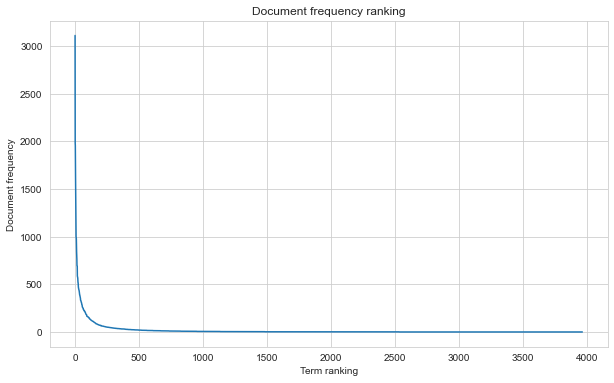

In [30]:
plt.figure(figsize=(10,6))
plt.plot([x[0] for x in prep_comments.df_ranking['tokens']])
plt.title('Document frequency ranking')
plt.ylabel("Document frequency")
plt.xlabel("Term ranking")
plt.show()


### Term Frequency LOG-LOG plot
* Power law yields a straight line in log-log plot

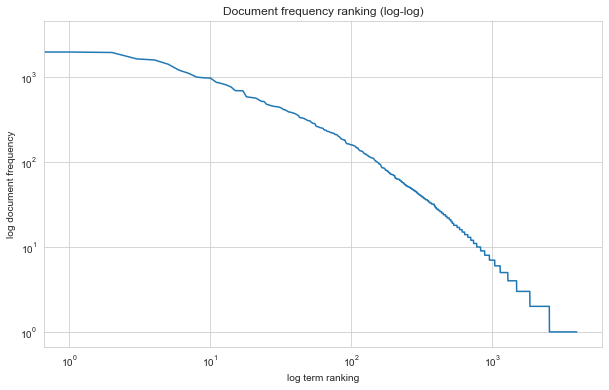

In [31]:
# we can use a log-log scale to observe more clearly the power-law distribution (Zipf's law)
plt.figure(figsize=(10,6))
plt.loglog([x[0] for x in prep_comments.df_ranking['tokens']])
plt.title('Document frequency ranking (log-log)')
plt.ylabel("log document frequency")
plt.xlabel("log term ranking")
plt.show()


### Term Frequency-Inverse Document Frequency plot

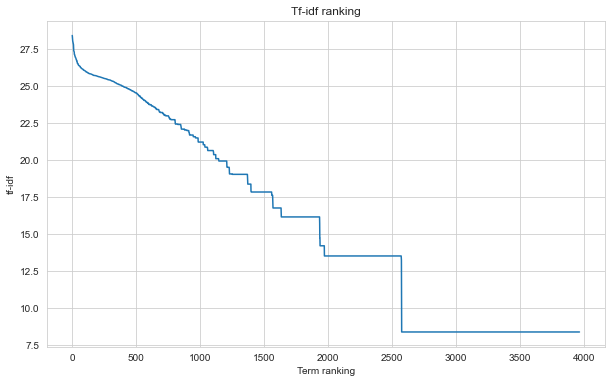

In [32]:
plt.figure(figsize=(10,6))
plt.plot([x[0] for x in prep_comments.tfidf_ranking['tokens']])
plt.title('Tf-idf ranking')
plt.ylabel("tf-idf")
plt.xlabel("Term ranking")
plt.show()


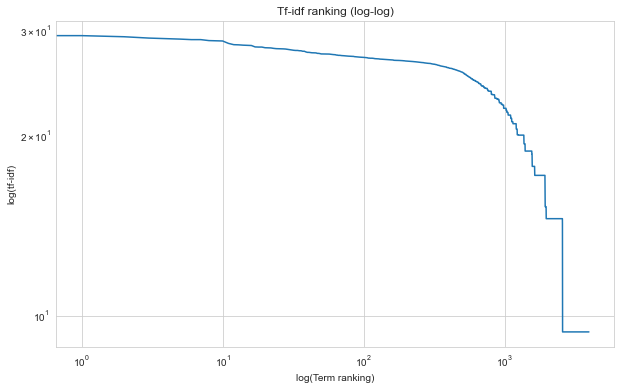

In [33]:
plt.figure(figsize=(10,6))
# add 1 to prevent taking log of zero
plt.loglog([1+x[0] for x in prep_comments.tfidf_ranking['tokens']])
plt.title('Tf-idf ranking (log-log)')
plt.ylabel("log(tf-idf)")
plt.xlabel("log(Term ranking)")
plt.show()

### Use CountVectorizer() for creating document term matrix for our project
* We apply no additional preprocessing as we have already "pre-processed" the comments (tokenization, removal of stop words, removal of punctuations etc.)
* We generate unigrams, i.e. each word as its own (in contrast to two words at a time joined together) for EDA purposes
    * When we undertake real analysis, we do add bigrams to our token set in order to capture sentiments. This is essential because we can capture sentiments such as "good-service", "bad-product", which will not be possible if we take each word seperately.
* In order to curb noise in our token analysis, we ignore tokens that have a frequency lower than 5 occurances in all documents
    * These frequency of occurances values can be adjusted by experimenting with various values.
    * In this preliminary analysis, we chose this number to show case capabilities. In production, we can decide on the exact numbers

In [34]:
# simple auxiliary function to override the preprocessing done by sklearn
def do_nothing(doc):
    return doc

# create a CountVectorizer object using our preprocessed text
count_vectorizer = CountVectorizer(encoding='utf-8',
                                   preprocessor=do_nothing,  # apply no additional preprocessing
                                   tokenizer=do_nothing,     # apply no additional tokenization
                                   lowercase=False,
                                   strip_accents=None,
                                   stop_words=None,
                                   ngram_range=(1, 1),       # generate only unigrams, bigrams
                                   analyzer='word',          # analysis at the word-level
                                   #max_df=0.5,              # ignore tokens that have a higher document frequency (can be int or percent)
                                   #min_df=500,                # ignore tokens that have a lowe document frequency (can be int or percent)
                                   min_df=5,
                                   max_features=None,        # we could impose a maximum number of vocabulary terms
                                   )

### Output document-term matrix

In [35]:
# transform our preprocessed tokens into a document-term matrix
dt_matrix = count_vectorizer.fit_transform(prep_comments.tokens)
print(f"Document-term matrix created with shape: {dt_matrix.shape}")

Document-term matrix created with shape: (8794, 1286)


### Associate words with positions in the matrix and print them
* The value in column "1" indicates the column number of the word in the document term matrix

In [36]:
# we can access a dictionary that maps between words and positions of the document-term matrix
# list(count_vectorizer.vocabulary_.items())[0:10]
id_word_indexer = pd.DataFrame(count_vectorizer.vocabulary_.items())
id_word_indexer

,0,1
0,contact,221
1,lenses,605
2,used,1203
3,for,434
4,long,624
...,...,...
1281,aspheric,72
1282,encore,342
1283,vertex,1214
1284,premium,828


In [37]:
## When we get all the values of a particular row using df.values, we then narrow it down to the specific column to determine the index. In our case, there are only
## two values, index 0 corresponds to name of the token and index 1 contains the index of the token in document term matrix
this_row = 0
required_value_index = 1
# find index of token product
product_index = id_word_indexer.loc[id_word_indexer[0] == 'product'].values[this_row][required_value_index]
service_index = id_word_indexer.loc[id_word_indexer[0] == 'service'].values[this_row][required_value_index]
quality_index = id_word_indexer.loc[id_word_indexer[0] == 'quality'].values[this_row][required_value_index]
price_index = id_word_indexer.loc[id_word_indexer[0] == 'price'].values[this_row][required_value_index]

### Dictionary methods
We do a simple analysis of our comments by looking for words that denote the topics:
* "product"
* "service"
* "quality"
* "price"
In order to find words that correspond to above topics, we find synonyms of words above and add to our vocabulary of words. We then use this comprehensive vocabulary to extract words in each document that correspond to the above words

* We use publicly available NLTK based WordNet to get synonyms of words

### Finding synonyms using WordNet for the words
This is a two step process. (This could be a multi-step process, but we get enough synonym words for two step process and we stop)

Step 1: Find synonyms using Wordnet for "product. service, quality, price"

Step 2: Use the resulting synonyms as starting set of words and find "more" synonyms.

  * Because the synonym words from the wordnet synonym finder may not be entirely suitable to be used automatically we filter the result (synonyms) obtained.
    Particularly, some words could be used in different sense (noun, adjective etc.) and only humans could determine different classification.
    Given that we know the domain here, we want to make sure that the synonyms we find don't add to the ambiguity.
    * For example, one of the synonyms for "ware" is "convenience" (as in mode of convenience).
          But this could also mean "ease of use", which would come under "quality" and not under "product", In order to avoid this, we manually filter out the output synonyms of wordnet results

In [38]:
product_words = ['gadget', 'contraption', 'appliance', 'widget', 'equipment', 'contrivance', 'gizmo', 'product', 'merchandise', 'ware', 'gismo']
service_words = ['service', 'assist', 'help', 'aid']
quality_words = ['quality', 'built', 'refurbish', 'comfort', 'relief']
price_words = ['price', 'money', 'cash', 'cheap', 'costly', 'pricey', 'discount', 'payment', 'rebate', 'cost']

Once we find the synonym words, we use these words and search each document (i.e., each row, each comment) and count the occurances of each for simple analysis later

### Product synonyms
* Only nouns are considered.

In [39]:
syns_indicating_product = find_wordnet_synonyms(product_words, wn.NOUN)

### Service synonyms

In [40]:
syns_indicating_service = find_wordnet_synonyms(service_words, wn.NOUN)

### Quality synonyms

In [41]:
syns_indicating_quality = find_wordnet_synonyms(quality_words, wn.NOUN)

### Price synonyms

In [42]:
syns_indicating_price = find_wordnet_synonyms(price_words, wn.NOUN)

### Find all tokens that correspond to "price, service, quality, product"

In [43]:
tokens_indicating_product = product_words
tokens_indicating_service = service_words
tokens_indicating_quality = quality_words
tokens_indicating_price = price_words

### Determine counts of each of the above topics in each comment made by the user.
* This information can be used for classification of documents that talk about 'service' or 'product' for example

### Find all token-ids corresponding to "product, price, quality, service" so we can add them up

In [44]:
# vocabulary's key is the feature word and the value is the feature-word's index in the feature column ...
service_indicator_token_ids = [v for k,v in count_vectorizer.vocabulary_.items() if k in tokens_indicating_service]
print(f"{len(service_indicator_token_ids)} tokens found in vocabulary indicating service, {service_indicator_token_ids}")

2 tokens found in vocabulary indicating service, [994, 517]


In [45]:
product_indicator_token_ids = [v for k,v in count_vectorizer.vocabulary_.items() if k in tokens_indicating_product]
print(f"{len(product_indicator_token_ids)} tokens found in vocabulary indicating product, {product_indicator_token_ids}")

1 tokens found in vocabulary indicating product, [853]


In [46]:
quality_indicator_token_ids = [v for k,v in count_vectorizer.vocabulary_.items() if k in tokens_indicating_quality]
print(f"{len(quality_indicator_token_ids)} tokens found in vocabulary indicating quality, {quality_indicator_token_ids}")

2 tokens found in vocabulary indicating quality, [191, 874]


In [47]:
price_indicator_token_ids = [v for k,v in count_vectorizer.vocabulary_.items() if k in tokens_indicating_price]
print(f"{len(price_indicator_token_ids)} tokens found in vocabulary indicating price, {price_indicator_token_ids}")

8 tokens found in vocabulary indicating price, [292, 839, 842, 160, 240, 677, 800, 900]


### Add up the number tokens in each document (i.e., for each row, each comment) that correspond to words "product, price,..." and its synonyms

In [48]:
service_indicator_counts = dt_matrix.tocsr()[:, service_indicator_token_ids]
# for a given data, count all such tokens that indicate service and presumably, one can add this as a new column to the data itself
service_indicator_counts = service_indicator_counts.sum(axis=1)
service_indicator_counts

matrix([[1],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]])

In [49]:
product_indicator_counts = dt_matrix.tocsr()[:, product_indicator_token_ids]
# for a given data, count all such tokens that indicate product and presumably, one can add this as a new column to the data itself
product_indicator_counts = product_indicator_counts.sum(axis=1)
np.array(product_indicator_counts).ravel()

array([0, 0, 0, ..., 0, 1, 0])

In [50]:
price_indicator_counts = dt_matrix.tocsr()[:, price_indicator_token_ids]
# for a given data, count all such tokens that indicate price and presumably, one can add this as a new column to the data itself
price_indicator_counts = price_indicator_counts.sum(axis=1)
np.array(price_indicator_counts).ravel()

array([0, 0, 0, ..., 0, 1, 0])

In [51]:
quality_indicator_counts = dt_matrix.tocsr()[:, quality_indicator_token_ids]
# for a given data, count all such tokens that indicate quality and presumably, one can add this as a new column to the data itself
quality_indicator_counts = quality_indicator_counts.sum(axis=1)
np.array(quality_indicator_counts).ravel()

array([0, 0, 1, ..., 0, 0, 0])

#### Determine counts of topics: "service, product, quality, price"
* We study these because it is important to know what customers think on these topics
* Counts of: service, product, quality, price

In [52]:
dt_matrix.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [53]:
# index 14 - service, 15-product, 16-quality, 17-price
topic_index_name_map = {}
topic_index_name_map[product_index] = 'product'
topic_index_name_map[service_index] = 'service'
topic_index_name_map[quality_index] = 'quality'
topic_index_name_map[price_index] = 'price'

### Check to see how many documents contains the topics words
* For each topic word ('price', 'service' etc.), how many documents contains 0, 1, 2, ... count of those words
* Just a sanity check to see if we counted proerly or not

In [54]:
# We want to s
for idx in [product_index, service_index, quality_index, price_index]:
    unique, counts = np.unique(dt_matrix.toarray()[:, idx], return_counts=True)
    print(f"Index:{idx}, topic: {topic_index_name_map[idx]}, values:\n{np.asarray((unique, counts)).T}")

Index:853, topic: product, values:
[[   0 8101]
 [   1  613]
 [   2   78]
 [   3    1]
 [   4    1]]
Index:994, topic: service, values:
[[   0 8227]
 [   1  476]
 [   2   83]
 [   3    6]
 [   4    2]]
Index:874, topic: quality, values:
[[   0 8413]
 [   1  323]
 [   2   52]
 [   3    6]]
Index:839, topic: price, values:
[[   0 8099]
 [   1  589]
 [   2  102]
 [   3    4]]


### Add count of topics as separate columns in data for easier analysis

In [55]:
text_data['service'] = np.array(service_indicator_counts).ravel()
text_data['product'] = np.array(product_indicator_counts).ravel()
text_data['quality'] = np.array(quality_indicator_counts).ravel()
text_data['price'] = np.array(price_indicator_counts).ravel()
text_data

,FINAL_PRODUCT_NAME,RATING,PRODUCT,BRAND,GENDER,COMMENT,service,product,quality,price
REVIEW_DATE,,,,,,,,,,
2021-11-01,Acuvue 2 Contact Lenses ...,5,Acuvue2,Acuvue,male,Acucue 2 Contact Lenses I have used these lens...,1,0,0,0
2021-12-02,Acuvue 2 Contact Lenses ...,4,Acuvue2,Acuvue,female,Clear vision Tends to cloud up,0,0,0,0
2021-12-01,Acuvue 2 Contact Lenses ...,4,Acuvue2,Acuvue,female,comfort These are very hard to handle. Flimsy ...,0,0,1,0
2021-11-16,Acuvue 2 Contact Lenses ...,5,Acuvue2,Acuvue,male,Easy to use I have been using this product for...,0,1,0,0
2021-12-08,Acuvue 2 Contact Lenses ...,4,Acuvue2,Acuvue,unknown,Excellent Excellent got promised a discount of...,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
2021-11-29,Acuvue VITA Contact Lenses ...,5,Vita,Acuvue,male,"Truly the Best The price, fast shipping, quic...",0,0,0,1
2021-11-23,Shop Acuvue Vita 12 pack (1.0 Box ),5,Vita,Acuvue,male,Very Comfortable Acuvue Vita are very comfort...,0,0,0,0
2021-12-27,Acuvue Vita for Astigmatism Contact Lenses,5,Vita,Acuvue,male,Very Comfortable and Convenient Very Comfortab...,0,0,0,0


### Let us find average rating, aggregated by 'price'

In [56]:
data_agg_price = text_data.groupby(['price'], as_index=False).agg({'COMMENT': 'sum', 'RATING':'mean'})
data_agg_price


,price,COMMENT,RATING
0,0,Acucue 2 Contact Lenses I have used these lens...,4.735465
1,1,Excellent Excellent got promised a discount of...,4.664393
2,2,"Good contacts, good price Good contacts, good ...",4.818182
3,3,"Great experience, great price First time purch...",4.615385
4,4,Helped offset eye care cost Rebate was integra...,3.000000
5,5,Rebate Lenses are fine. I do not like the reb...,2.000000
6,7,Use Your Benefits to the MAX! After my provide...,5.000000


### let us find average rating, aggregated by 'service'

In [57]:
data_agg_service = text_data.groupby(['service'], as_index=False).agg({'COMMENT': 'sum', 'RATING':'mean'})
data_agg_service

,service,COMMENT,RATING
0,0,Clear vision Tends to cloud upcomfort These ar...,4.740696
1,1,Acucue 2 Contact Lenses I have used these lens...,4.581673
2,2,Great service over all Great service! Could ha...,4.738636
3,3,Fast service love rebates Fast service. Rebate...,3.142857
4,4,"Service, Service, Service! I have always recei...",3.000000


### let us find average rating, aggregated by 'quality'

In [58]:
data_agg_quality = text_data.groupby(['quality'], as_index=False).agg({'COMMENT': 'sum', 'RATING':'mean'})
data_agg_quality

,quality,COMMENT,RATING
0,0,Acucue 2 Contact Lenses I have used these lens...,4.724904
1,1,comfort These are very hard to handle. Flimsy ...,4.754296
2,2,Good quality and comfort NA2Very nice lens. I ...,4.908451
3,3,"Consistent Quality Great, high quality contact...",4.750000
4,4,Good quality and comfort Good quality and comf...,5.000000


In [59]:
text_data

,FINAL_PRODUCT_NAME,RATING,PRODUCT,BRAND,GENDER,COMMENT,service,product,quality,price
REVIEW_DATE,,,,,,,,,,
2021-11-01,Acuvue 2 Contact Lenses ...,5,Acuvue2,Acuvue,male,Acucue 2 Contact Lenses I have used these lens...,1,0,0,0
2021-12-02,Acuvue 2 Contact Lenses ...,4,Acuvue2,Acuvue,female,Clear vision Tends to cloud up,0,0,0,0
2021-12-01,Acuvue 2 Contact Lenses ...,4,Acuvue2,Acuvue,female,comfort These are very hard to handle. Flimsy ...,0,0,1,0
2021-11-16,Acuvue 2 Contact Lenses ...,5,Acuvue2,Acuvue,male,Easy to use I have been using this product for...,0,1,0,0
2021-12-08,Acuvue 2 Contact Lenses ...,4,Acuvue2,Acuvue,unknown,Excellent Excellent got promised a discount of...,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
2021-11-29,Acuvue VITA Contact Lenses ...,5,Vita,Acuvue,male,"Truly the Best The price, fast shipping, quic...",0,0,0,1
2021-11-23,Shop Acuvue Vita 12 pack (1.0 Box ),5,Vita,Acuvue,male,Very Comfortable Acuvue Vita are very comfort...,0,0,0,0
2021-12-27,Acuvue Vita for Astigmatism Contact Lenses,5,Vita,Acuvue,male,Very Comfortable and Convenient Very Comfortab...,0,0,0,0


### Let us find average rating by month

In [60]:
data_agg_time = text_data.groupby(pd.Grouper(freq='M'), as_index=False).agg({'COMMENT': 'sum', 'RATING':'mean'})
data_agg_time

,COMMENT,RATING
0,Can wear all day and night NA2Yes Quotidiennem...,4.741522
1,Acucue 2 Contact Lenses I have used these lens...,4.760583
2,comfort These are very hard to handle. Flimsy ...,4.693370


### A way to convert document matrix into a matrix with documents as rows and token names (instead of token id) as columns for further analysis

In [61]:
## FOR SVM, we need to make a matrix with proper column names
# Also, we need another column that denotes the review
# We also need to normalize the data
df_svm = pd.DataFrame(dt_matrix.toarray())
df_svm.rename(columns=id_word_indexer.to_dict()[0], inplace=True)
df_svm

,contact,lenses,used,for,long,time,and,say,service,from,...,sofmed,preference,compatibles,sphere,expressions,aspheric,encore,vertex,premium,view
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8789,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8790,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8791,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8792,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,1,0,0,0
